In [1]:
# !pip install datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import string, re

from keras.layers import TextVectorization

from sklearn.model_selection import train_test_split



In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_polarity.csv')

In [4]:
df.label.value_counts()

label
0    500645
1    499355
Name: count, dtype: int64

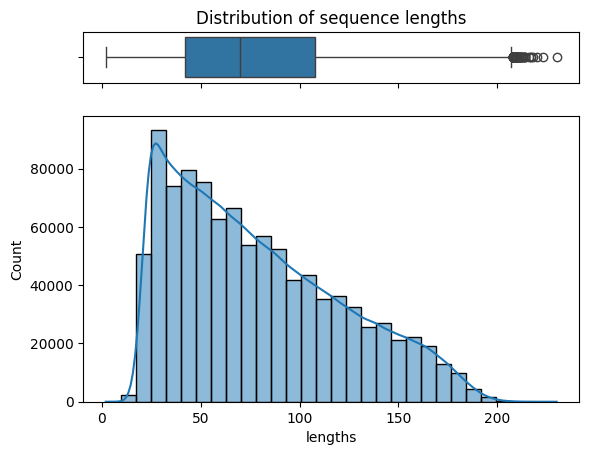

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Add a graph in each part
sns.boxplot(x=df["lengths"], ax=ax_box)
ax_box.set_title('Distribution of sequence lengths')

sns.histplot(df["lengths"],kde=True, bins=30, ax=ax_hist)

ax_box.set(xlabel='')
plt.savefig('distribution of sequence lengths.png')

plt.show()

In [18]:

df.lengths.describe()

count    1000000.000000
mean          78.504331
std           42.868783
min            2.000000
25%           42.000000
50%           70.000000
75%          108.000000
max          230.000000
Name: lengths, dtype: float64

## Train/Test *Split*

In [ ]:
y = df.label.values
X = df.combined_text.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42)

In [ ]:
len(X_train), \
len(X_val), \
len(X_test)

(800000, 100000, 100000)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
for rev, l in train_dataset.take(1):
  rev = rev
  print(rev)
  print(l)

tf.Tensor(b"Buy the older version Although I love the Akira story and everything about it, the special edition changed many things about the original. for one thing, the character's voices are different! am i alone in the group that thinks that is a really stupid maneauver? I'm really pissed that they would do such a thing. I LIKED the way Koneda's voice sounds when he's yelling at Tetsuo. I liked how twisted Tetsuo's voice becomes throughout the film. I liked the sounds of everyone els'es voice in the movie. why in the hell did they change that??! stupid morons. The movie is great, but if you want the real feel of the movie, go back to the original version of the movie. it's much much much better.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Building the TextVectorization Layer

In [ ]:
def standardization(review):
    lowercase = tf.strings.lower(review)
    notag = tf.strings.regex_replace(lowercase, "<[^>]+>", "")
    nourl = tf.strings.regex_replace(notag, r"http\S+", "")
    no_special_chars = tf.strings.regex_replace(nourl, "[%s]" % re.escape(string.punctuation), "")
    ascii_only = tf.strings.regex_replace(no_special_chars, "[^\x00-\x7F]+", "")
    clean_whitespace = tf.strings.strip(tf.strings.regex_replace(ascii_only, r"\s+", " "))
    return clean_whitespace

In [ ]:
rev = tf.constant("\xf0\x9f\x91\x8c\xf0\x9f\x91\x8c \xf0\x9f\x91\x8c\xf0\x9f\x91\x8d\xf0\x9f\x91\x8c\xf0\x9f\x91\x8d")
standardization(rev)

<tf.Tensor: shape=(), dtype=string, numpy=b''>

In [ ]:
SEQUENCE_LEN = int(np.percentile(df.lengths, 95))
VOCAB_SIZE = 30000
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardization,
    output_mode="int",
    output_sequence_length=SEQUENCE_LEN)

In [ ]:
SEQUENCE_LEN

161

In [ ]:
X_train = train_dataset.map(lambda x, y: x)

In [ ]:
X_train

<_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
vectorize_layer.adapt(X_train)

In [ ]:
len(vectorize_layer.get_vocabulary())

30000

In [ ]:
def vectorizer(review, label):
  return vectorize_layer(review), label

In [ ]:
train_dataset = train_dataset.map(vectorizer)
val_dataset = val_dataset.map(vectorizer)
test_dataset = test_dataset.map(vectorizer)

In [ ]:
filtered_train_dataset = train_dataset.filter(lambda x, y: tf.not_equal(tf.shape(x)[0], 0))

In [ ]:
filtered_val_dataset = val_dataset.filter(lambda x, y: tf.not_equal(tf.shape(x)[0], 0))
filtered_test_dataset = test_dataset.filter(lambda x, y: tf.not_equal(tf.shape(x)[0], 0))

In [ ]:
for x,y in filtered_train_dataset.take(2):
  print(x, y)

tf.Tensor(
[   83     2   731   247   362     4    80     2 16471   106     3   289
    41     8     2   562   632   879   110   237    41     2   264    12
    25   163     2   180  1870    24   205    94     4   840    11     2
   755    13  1715    13    10     5    65   719     1   108    65  6946
    13    34    40    67   209     5   163     4   372     2   107     1
   409   424    50   639  7826    36     1     4   372    87  3171     1
   409  1348   848     2   173     4   372     2   424     7   403  5360
   409    11     2    63   178    11     2  1112   101    34   538    13
   719  9646     2    63    10    30    18    31    16   130     2   192
   228     7     2    63   143   114     6     2   264   247     7     2
    63    35    72    72    72    91     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0], shape=(

In [ ]:
for x,y in train_dataset.take(1):
  print(x.numpy().shape)
  print(y.numpy())

(161,)
0


In [ ]:
BATCH_SIZE = 32
train_ds = filtered_train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = filtered_val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# for x,y in train_ds.take(2):
#   print(x, y)

## Integrating Pre-trained Word2Vec Layer

In [ ]:
import gensim.downloader as api

In [ ]:
api.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [ ]:
word2vec_google_news = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
word2vec_pretrained_embeddings = []
n=0
for i, word in enumerate(vectorize_layer.get_vocabulary()):
  try:
    embedding_vector = word2vec_google_news[word]
    word2vec_pretrained_embeddings.append(embedding_vector)

  except KeyError:
    word2vec_pretrained_embeddings.append(np.random.uniform(-1, 1, 300))
    print(word)


  if i % 1000==0:
    print(i)

Streaming output truncated to the last 5000 lines.
11i
11e
11and
116th
11634
115
113
1110
10xs
10se
10no
10mnts
10min
10l
10it
10inch
10foot
10a
1080p
1060p
1034
1032
1013
100watt
100satisfied
100percent
100aaa
100100
10010
099
07
05mm
001
zxe
zthe
zthanks
ztetoo
ztemax
ztegrand
zs
zper
zowee
zootopia
zoomteams
zoomit
zoomfacetime
zoomdont
zomgwtfd
zoey
znitro
zmaz
zmaxnot
zlots
zizy
zizi
ziz
ziyi
zirping
ziptied
zippersa
zippering
ziper
zincplated
ziltch
ziao
zhegailian
zforce
zfold3
zflio
zeroreturned
zerophone
zeronice
zerojust
zerobecause
zero3
zenwatch3
zenphone
zenfone3
zenfone2
zeiss
zeeno
zebrasworks
ze551
zc520tl
zbout
zas
zadovoljan
zacro
zabraplus
z998
z992
z799vl
z71
z500a
z4larry
z3v
z3play
z30
z1thanks
z1h
yyuupp
yyour
yx
yuzihan
yuwis
yuse
yus
yupstrongyup
yupperfect
yupits
yuphighly
yumtumtum
yummly
yulk
yukyuk
yuckydo
yuckno
yuckfeels
yubi
yuanvery
ytip
ythis
ything
ythere
yrsno
yre
ypuse
ypoint
yoyr
youworks
youwill
youvery
youv
youuuuuuuuuuuuuuu
youupdate
youtuve
you

In [ ]:
word2vec_pretrained_embeddings = np.array(word2vec_pretrained_embeddings)

## Model Building

In [ ]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Bidirectional, GRU, Conv1D, Input, Embedding, Dense, Flatten, Dropout, InputLayer
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=True)

In [ ]:
csv_logger = CSVLogger('log_ls_30.csv', append=True, separator=',')

In [ ]:
EMBEDDING_DIMS = 300


In [ ]:
lstm_model1 = Sequential([
    InputLayer(input_shape=(SEQUENCE_LEN,)),
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIMS),
              # embeddings_initializer=tf.keras.initializers.Constant(word2vec_pretrained_embeddings),
              # trainable=True),
    LSTM(32, return_sequences=True,dropout=0.6),
    LSTM(16),
    Dense(1, activation="sigmoid")
])

lstm_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 161, 300)          9000000   
                                                                 
 lstm (LSTM)                 (None, 161, 32)           42624     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 9045777 (34.51 MB)
Trainable params: 9045777 (34.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_model1.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
lstm_model1.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stop, csv_logger])

Epoch 1/100
25000/25000 [==============================] - 597s 24ms/step - loss: 0.2998 - accuracy: 0.8472 - val_loss: 0.1554 - val_accuracy: 0.9411
Epoch 2/100
25000/25000 [==============================] - 538s 22ms/step - loss: 0.1473 - accuracy: 0.9445 - val_loss: 0.1489 - val_accuracy: 0.9449
Epoch 3/100
25000/25000 [==============================] - 528s 21ms/step - loss: 0.1318 - accuracy: 0.9513 - val_loss: 0.1531 - val_accuracy: 0.9450
Epoch 4/100
25000/25000 [==============================] - 528s 21ms/step - loss: 0.1232 - accuracy: 0.9549 - val_loss: 0.1531 - val_accuracy: 0.9446
Epoch 5/100
25000/25000 [==============================] - 544s 22ms/step - loss: 0.1177 - accuracy: 0.9574 - val_loss: 0.1583 - val_accuracy: 0.9440


In [ ]:

full_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),  # Input layer expecting strings
    vectorize_layer,
    lstm_model1
])


In [ ]:
full_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 161)               0         
 ctorization)                                                    
                                                                 
 sequential (Sequential)     (None, 1)                 9045777   
                                                                 
Total params: 9045777 (34.51 MB)
Trainable params: 9045777 (34.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
full_model.predict(['the product is very good', 'the product is not good'])

1/1 [==============================] - 2s 2s/step


array([[0.9828446 ],
       [0.00485183]], dtype=float32)

In [ ]:
full_model.save('/content/drive/MyDrive/lstm_with_vectorizer/')

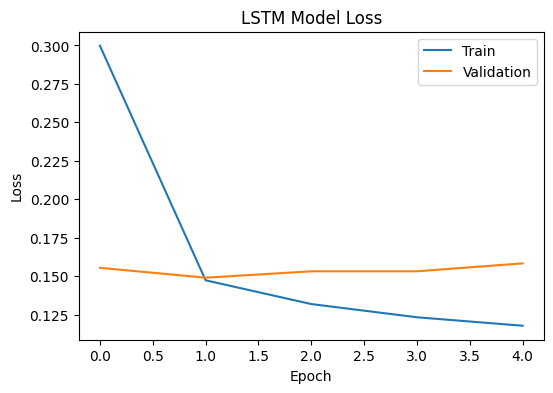

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(lstm_model1.history.history['loss'])
plt.plot(lstm_model1.history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('lstm_model_loss.png')

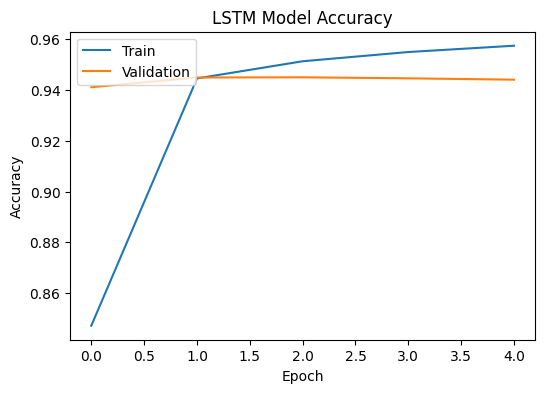

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(lstm_model1.history.history['accuracy'])
plt.plot(lstm_model1.history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('lstm_model_acc.png')

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
y_pred = lstm_model1.predict(val_ds)

3125/3125 [==============================] - 32s 10ms/step


In [ ]:
X_test.shape

(100000,)

In [ ]:
y_test.shape

(100000,)

In [ ]:
y_pred = full_model.predict(X_test)

3125/3125 [==============================] - 40s 13ms/step


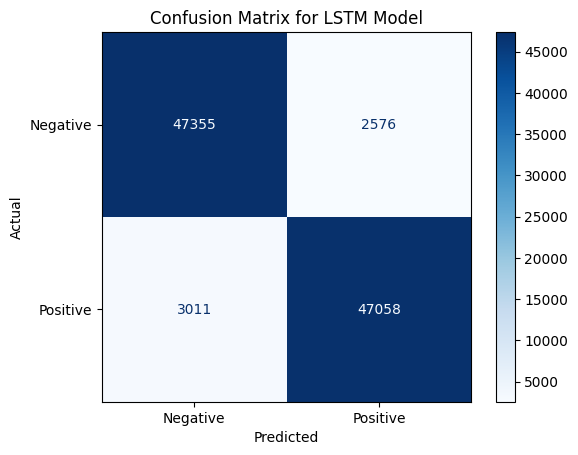

In [ ]:
import numpy as np

y_pred_classes = (y_pred > 0.5).astype(int)

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_classes,
    labels=[0, 1],
    display_labels=['Negative', 'Positive'],
    cmap=plt.cm.Blues
)

ax = disp.ax_
ax.set_title(f'Confusion Matrix for LSTM Model')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.savefig('confusion matrix for LSTM model.png')
plt.show()

In [ ]:
y_pred = y_pred_classes

In [ ]:
acc = accuracy_score(y_test, y_pred)
preci = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recal = recall_score(y_test, y_pred)
{'Accuracy': acc, 'f1_score': f1, 'Precision': preci, 'Recall':recal}


{'Accuracy': 0.94413,
 'f1_score': 0.9439635718082705,
 'Precision': 0.9481000926784059,
 'Recall': 0.9398629890750764}

In [ ]:
lstm_model1.save('lstm_model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# prompt: save the vocab

import pickle

with open('/content/drive/MyDrive/vocab.pkl', 'wb') as f:
  pickle.dump(vectorize_layer.get_vocabulary(), f)
